# Transfer Learning for Image Classification using Torchvision, Pytorch and Python

1.	Import
2.	Preprocess plus address any issues
3.	Batch normalization
4.	Linear calculation during training is used for batch normalization during testing
5.	Model or feature engineering
6.	Training and testing
7.	Precision, recall, F1 and accuracy tables
8.	Accuracy and loss


Will this model be ready for the real world?

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.25.2
pandas     : 2.0.3
torch      : 2.3.0+cu121
torchvision: 0.18.0+cu121



In [5]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Recognizing traffic signs

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 43 traffic signs. Given an image, it is important to recognize the traffic sign on it.

In [6]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2024-06-03 14:56:35--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  20.7MB/s    in 15s     

2024-06-03 14:56:51 (17.3 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration

We start by getting a feel of the data. The images for each traffic sign are stored in a separate directory. How many is it?

In [7]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

I created 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [8]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

See some examples for each traffic sign below:

<ipython-input-8-d18a9dfb7726>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  images = torch.as_tensor(images)


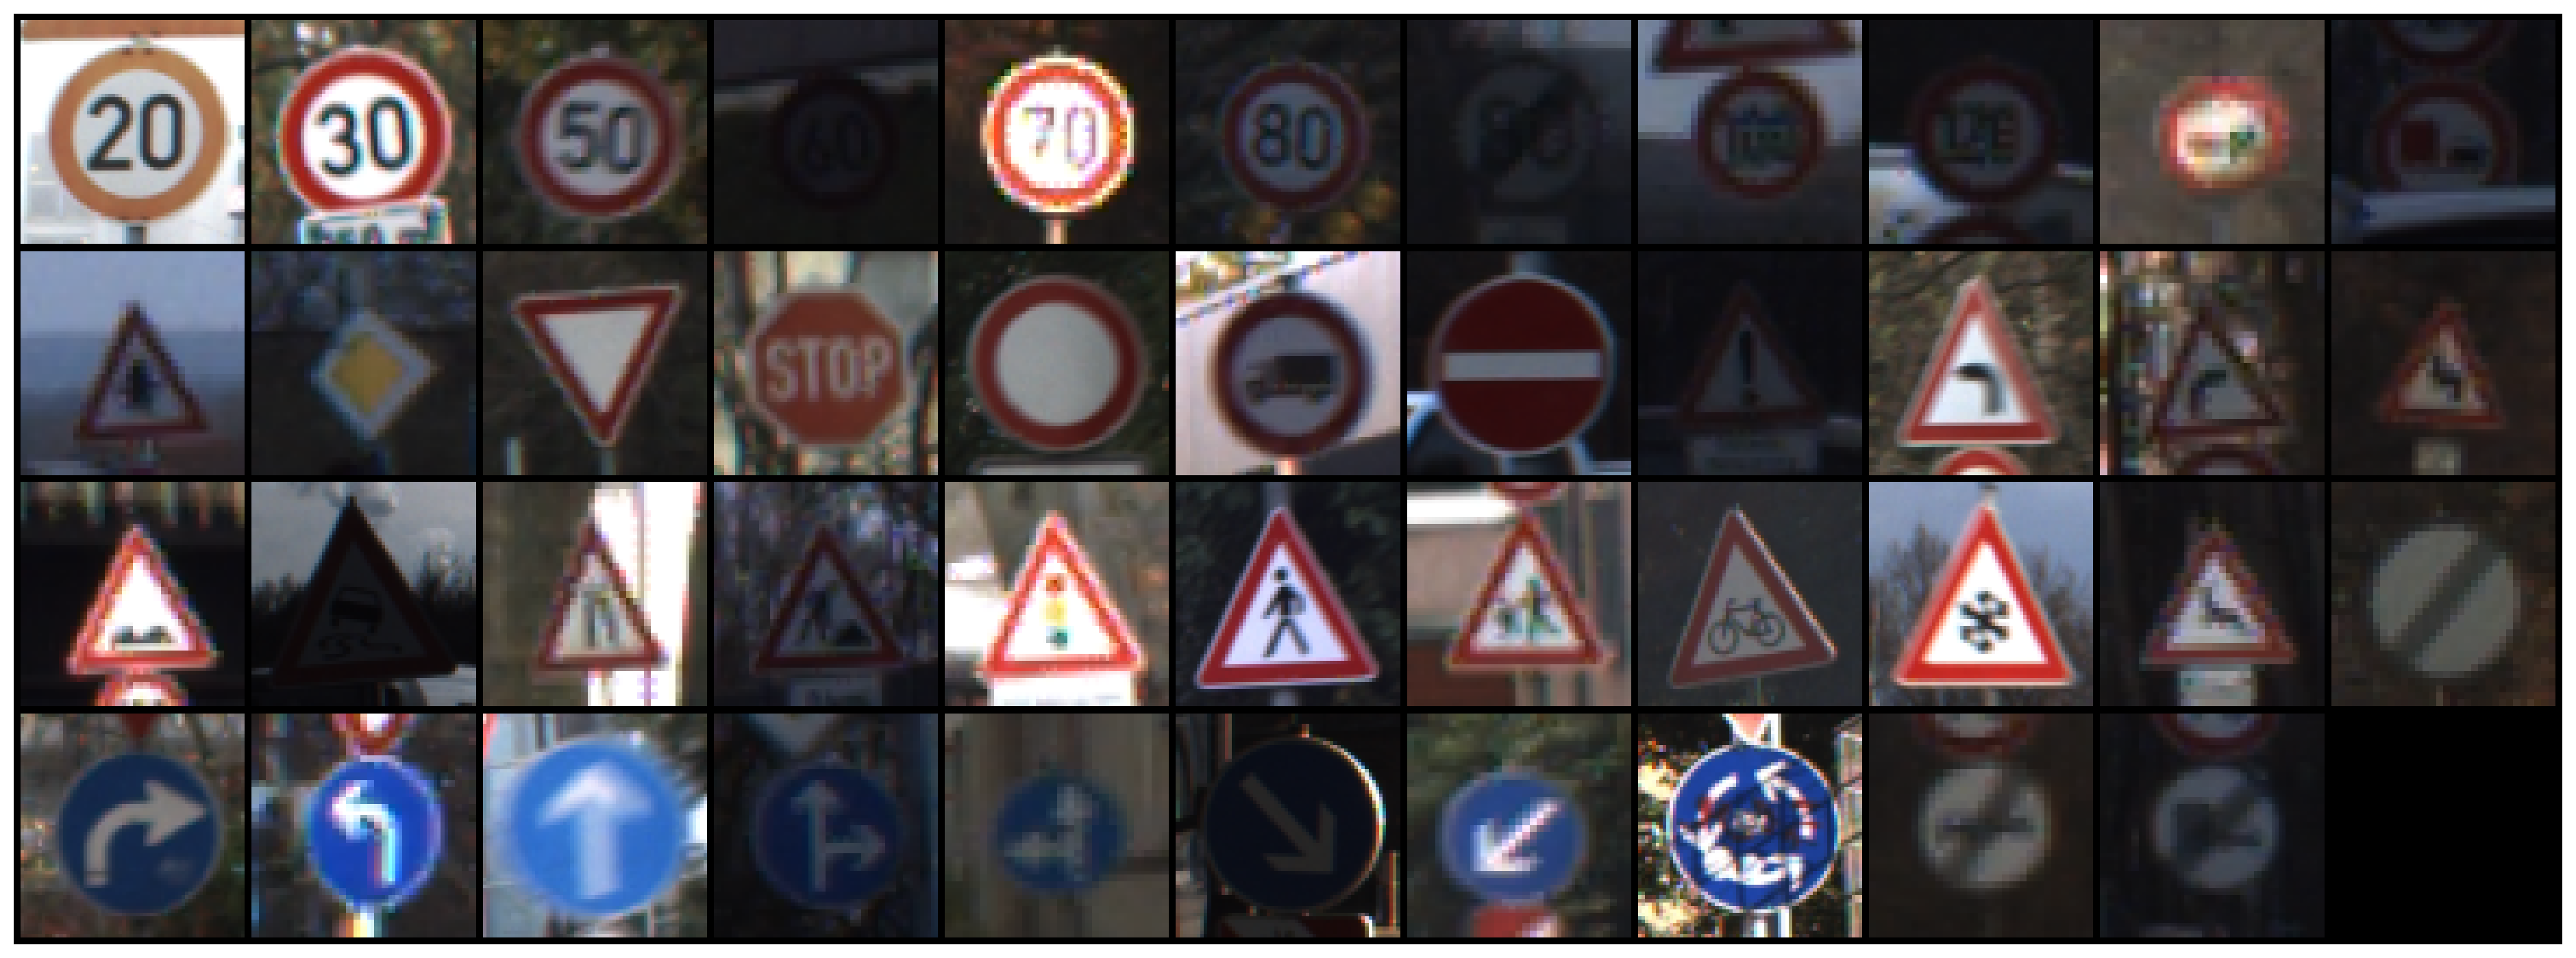

In [9]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

And here is a single sign:

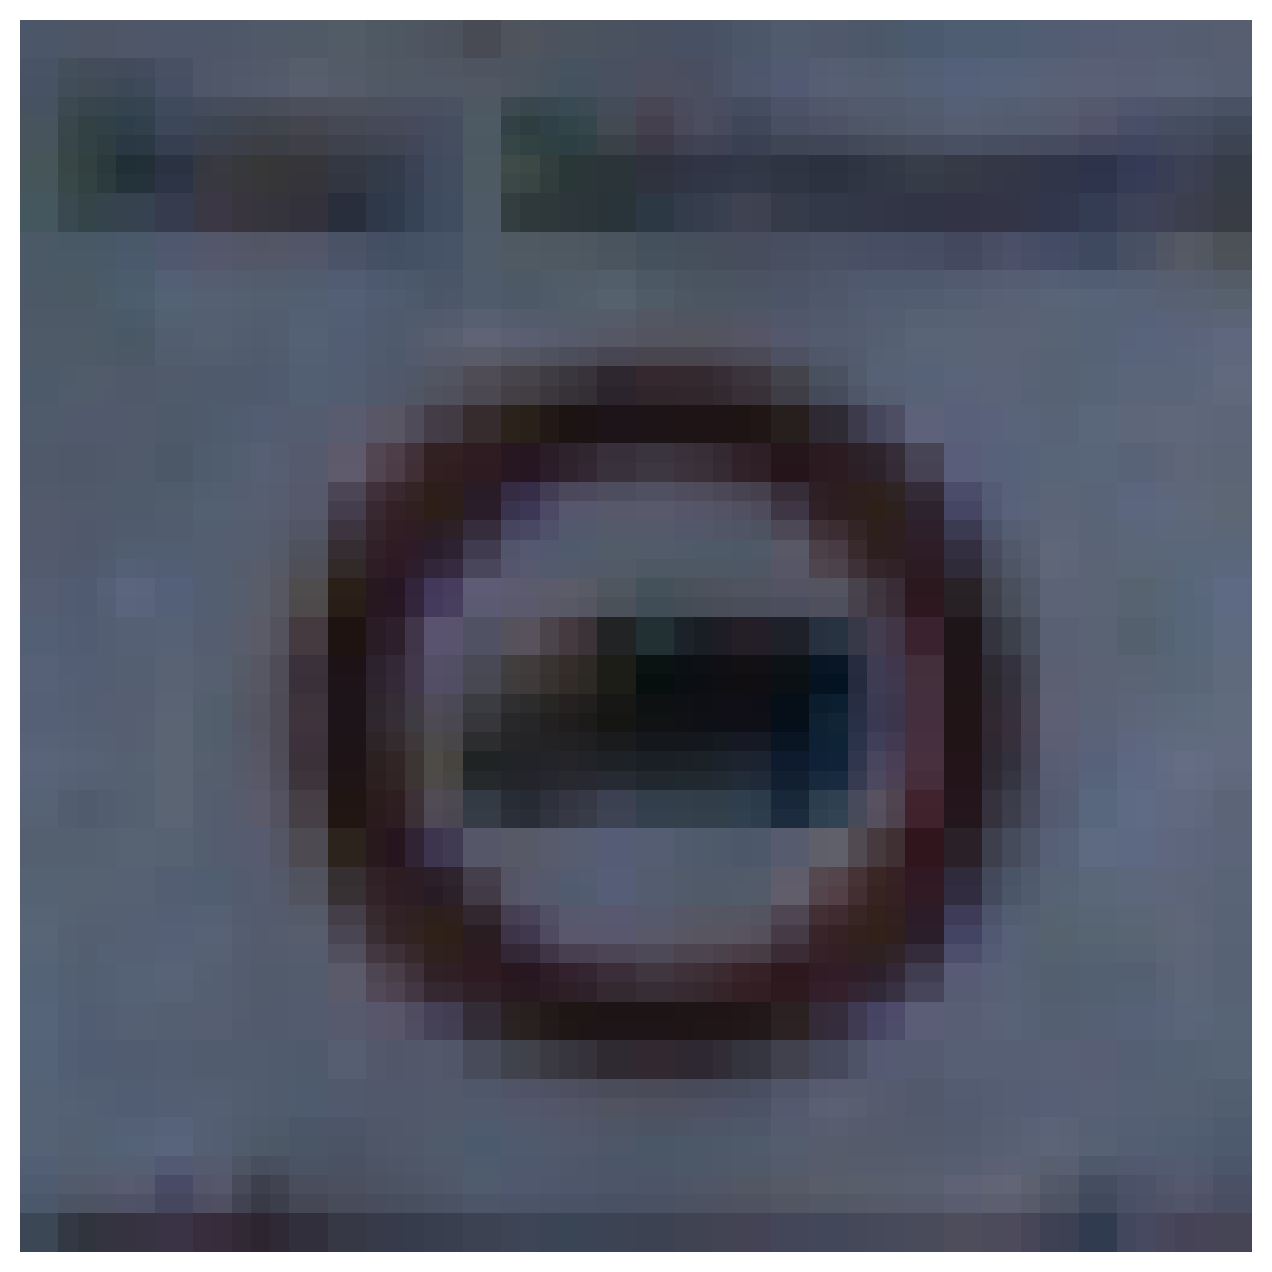

In [10]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building a dataset

To keep things simple, the focus is shifted to classifying some of the most used traffic signs:

In [11]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

The images files are copied to a new directory, so it's easier to use the Torchvision's dataset helpers, starting with with the directories for each class:

In [12]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

I will reserve 80% of the images for training, 10% for validation, and 10% test for each class and then copy each image to the correct dataset directory:

In [13]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


There is some level of class imbalance, but it is not that bad and so will be ignored.

Some image augmentation techniques will be applied to artificially increase the size of our training dataset:

In [14]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Then apply some random resizing, rotation, and horizontal flips. Finally, tensor is normalized using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

PyTorch dataset will be created for each image dataset folder and data loaders for easier training:

In [15]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We'll also store the number of examples in each dataset and class names for later:

In [16]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

The some examples are looked at with applied transformations.

There is need to also reverse the normalization and reorder the color channels to get correct image data:

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:

The model will receive raw image pixels and try to classify them into one of four traffic signs.

Here, i will use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the very popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, i will use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/). All of this is made easy to use by Torchvision:

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

All images are reused except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

So, we create an instance of our model:

In [ ]:
base_model = create_model(len(class_names))

In [ ]:
base_model

### Training

So, 3 helper functions to encapsulate the training and evaluation logic, starting with `train_epoch`:

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

The model is then turned into train mode and data reviewed. After getting the predictions, the class with maximum probability along with the loss is obtained, so we can calculate the epoch loss and accuracy.

Note that we are also using a learning rate scheduler (more on that later).

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that no gradient calculations are done.

Putting everything together:

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history


A lot of string formatting and recording of the training history is done. The hard stuff gets delegated to the previous helper functions. It is also key to get the best model, so the weights of the most accurate model(s) get stored during the training.

Training the first model:

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Then a little helper function that visualizes the training history:

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')


In [ ]:
plot_training_history(history)

The pre-trained model is so good that a high accuracy and low loss were obtained after 3 epochs. Unfortunately, the validation set is too small to get some meaningful metrics from it.

### Evaluation

Predictive evaluation to see some predictions on traffic signs from the test set:

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
show_predictions(base_model, class_names, n_images=8)

Great! Even the almost not visible *priority road* sign is classified correctly. Then the next step.

I will start by getting the predictions from the model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

The classification report shows us that the model is perfect, not something that is seen every day.

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

No, no mistakes here!

### Classifying unseen images

Ok, but how good will the model will be when confronted with a real-world image?

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

In [ ]:
show_image('stop-sign.jpg')

For this, i will check the confidence for each class. This will be obtained from the model:

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

This is a bit hard to understand. Let's plot it:

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

In [ ]:
show_prediction_confidence(pred, class_names)

Again, the model is performing very well! Really confident in the correct traffic sign!

### Classyfing unknown traffic sign

The last challenge for our model is a traffic sign that it has not seen before:

In [ ]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

In [ ]:
show_image('unknown-sign.jpg')

Get the predictions:

In [ ]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

In [ ]:
show_prediction_confidence(pred, class_names)

The model is very certain (more than 95% confidence) that this is a *give way* sign. This is obviously wrong and will have to be adjusted for.

## Adding class "unknown"

While there are a variety of ways to handle this situation (one described in this paper: [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/pdf/1610.02136.pdf)).

The indices of all traffic signs that were not included in the original dataset will be analysed:

In [ ]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

I will create a new folder for the unknown class and copy some of the images there:

In [ ]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what has been done already:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

In [ ]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

In [ ]:
plot_training_history (history)

Again, the model is learning very quickly. So, we look at the sample image again:

In [ ]:
show_image('unknown-sign.jpg')

In [ ]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

Great, the model does not give much weight to any of the known classes. It does not magically know that this is a two-way sign, but recognizes is as unknown.

So, taking a look at some examples of the new dataset:

In [ ]:
show_predictions(enchanced_model, class_names, n_images=8)

Let's get an overview of the new model's performance:

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history2 = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    test_acc, test_loss = eval_model(
      model,
      data_loaders['test'],
      loss_fn,
      device,
      dataset_sizes['test']
    )

    print(f'Test   loss {test_loss} accuracy {test_acc}')
    print()

    history2['train_acc'].append(train_acc)
    history2['train_loss'].append(train_loss)
    history2['test_acc'].append(test_acc)
    history2['test_loss'].append(test_loss)

    if test_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = test_acc

  print(f'Best test accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history2


In [ ]:
%%time

base_model, history2 = train_model(base_model, data_loaders, dataset_sizes, device)

In [ ]:
def plot_training_history(history2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history2['train_loss'], label='train loss')
  ax1.plot(history2['test_loss'], label='test loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epochs')

  ax2.plot(history2['train_acc'], label='train accuracy')
  ax2.plot(history2['test_acc'], label='test accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')

  fig.suptitle('Training history')


In [ ]:
plot_training_history(history2)

In [ ]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

In [ ]:
plot_training_history (history2)

The model is still perfect. So we try it on more images

## Summary

Here! I trained two different models for classifying traffic signs from raw pixels. Also, i built a dataset that is compatible with Torchvision.

*Using ResNet34 and Transfer Learning.